In [1]:
# ===== Packages =====
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt

plt.style.use("classic")
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{ebgaramond}",
    }
)


In [9]:
# ===== Simulation: Generate Data Progress =====
def generate_simulation_data(
    n_items=50, n_time=100, true_theta=-2.0, noise_level=0.001, seed=42
):
    """
    生成包含混杂因素和测量误差的模拟数据

    Args:
        n_items: 商品数量
        n_time: 时间点数量
        true_theta: 真实的弹性系数 (Ground Truth)
        noise_level: 第一阶段预测的噪音水平 (用于制造 Naive DML 的衰减偏差)
        seed: 随机种子

    Returns:
        df: 包含原始数据和模拟残差的 DataFrame
    """
    np.random.seed(seed)
    N = n_items * n_time

    # 1. 生成 ID 和 混杂因素
    item_ids = np.repeat(np.arange(n_items), n_time)

    # 商品固定效应: 高质量 -> 高价格
    alpha_i = np.random.normal(0, 1, n_items)[item_ids]

    # 时间混杂因素: 旺季 -> 高价格
    time_ids = np.tile(np.arange(n_time), n_items)
    seasonality = np.sin(time_ids / 10) + np.random.normal(0, 0.2, N)

    # 2. 生成原始价格 P
    # 假设 P 与 alpha, S 正相关 -> 制造 Raw OLS 的正向偏差
    ln_P = 1.0 * alpha_i - 0.5 * seasonality + np.random.normal(0, 0.5, N)

    # 3. 生成原始销量 Q
    # ln Q = theta * ln P + alpha + S + error
    ln_Q = (
        true_theta * ln_P
        + 1.0 * alpha_i
        + 1.0 * seasonality
        + np.random.normal(0, 0.5, N)
    )

    # 4. 模拟 DML 第一阶段
    # 计算"真实"的残差
    p_resid_true = ln_P - (1.0 * alpha_i + 0.5 * seasonality)
    q_resid_true = ln_Q - (1.0 * alpha_i + 1.0 * seasonality)

    # 生成"估算"的残差
    # 模拟 ML 模型没能完美预测，留下了噪音
    p_resid_est = p_resid_true + np.random.normal(0, noise_level, N)
    q_resid_est = q_resid_true + np.random.normal(0, noise_level, N)

    # 5. 封装数据
    df = pd.DataFrame(
        {
            "item_id": item_ids,
            "ln_P": ln_P,
            "ln_Q": ln_Q,
            "P_resid": p_resid_est,  # 用于 DML 计算
            "Q_resid": q_resid_est,  # 用于 DML 计算
        }
    )

    return df


In [10]:
# ===== Simulation: Construct Estimators =====
def calc_four_estimators(df):
    """
    计算 Raw OLS, De-meaned, Naive DML, Robust DML 四种估计量
    """
    results = {}

    # --- 1. Raw OLS ---
    # 忽略所有混杂因素，直接回归
    model_raw = sm.OLS(df["ln_Q"], sm.add_constant(df["ln_P"])).fit()
    results["Raw OLS"] = model_raw.params["ln_P"]

    # --- 2. De-meaned (Fixed Effects) ---
    # 去除商品固定效应，但无法去除随时间变化的 Seasonality
    df_fe = df.copy()
    df_fe["ln_Q_dm"] = df_fe["ln_Q"] - df_fe.groupby("item_id")["ln_Q"].transform(
        "mean"
    )
    df_fe["ln_P_dm"] = df_fe["ln_P"] - df_fe.groupby("item_id")["ln_P"].transform(
        "mean"
    )

    model_fe = sm.OLS(df_fe["ln_Q_dm"], df_fe["ln_P_dm"]).fit()
    results["De-meaned"] = model_fe.params["ln_P_dm"]

    # --- 3. Naive DML ---
    # 直接回归残差: Cov(res_p, res_q) / Var(res_p)
    # 受噪音影响，分母变大，系数衰减
    model_naive = sm.OLS(df["Q_resid"], df["P_resid"]).fit()
    results["Naive DML"] = model_naive.params["P_resid"]

    # --- 4. Robust DML (Chernozhukov) ---
    # 改进公式: Cov(res_p, res_q) / Cov(res_p, P_original)
    # 利用原始 P 修正分母，抵消噪音

    # 分子: residual covariance
    num = np.dot(df["P_resid"], df["Q_resid"])

    # 分母: residual correlated with original price (关键!)
    den = np.dot(df["P_resid"], df["ln_P"])

    results["Robust DML"] = num / den

    return results


Target True Theta: -1.0
Raw OLS      : -0.5013 (Bias: 0.4987)
De-meaned    : -1.6575 (Bias: -0.6575)
Naive DML    : -0.7288 (Bias: 0.2712)
Robust DML   : -1.0095 (Bias: -0.0095)


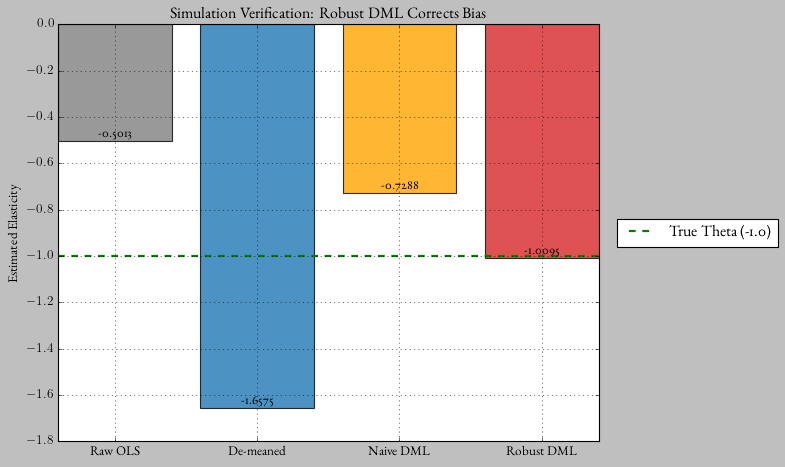

In [11]:
# ===== Simulation: Experiment and Diagnostics =====
def run_verification_experiment():
    # 1. 设定真实弹性
    TRUE_THETA = -1.0

    # 2. 生成数据
    df_sim = generate_simulation_data(true_theta=TRUE_THETA, noise_level=0.001)

    # 3. 计算估计量
    estimates = calc_four_estimators(df_sim)

    # 4. 打印结果
    print(f"{'=' * 40}")
    print(f"Target True Theta: {TRUE_THETA}")
    print(f"{'=' * 40}")
    for method, value in estimates.items():
        bias = value - TRUE_THETA
        print(f"{method:<12} : {value:.4f} (Bias: {bias:.4f})")
    print(f"{'=' * 40}")

    # 5. 绘图 (用于 Slide)
    plt.figure(figsize=(10, 6))

    methods = list(estimates.keys())
    values = list(estimates.values())
    colors = ["gray", "tab:blue", "orange", "tab:red"]

    bars = plt.bar(methods, values, color=colors, alpha=0.8)

    # 绘制真实值参考线
    plt.axhline(
        TRUE_THETA,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"True Theta ({TRUE_THETA})",
    )

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.4f}",
            ha="center",
            va="bottom" if height < 0 else "top",
        )

    plt.title("Simulation Verification: Robust DML Corrects Bias")
    plt.ylabel("Estimated Elasticity")
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.grid()
    plt.tight_layout()
    plt.savefig("simulation_verification.pdf")
    plt.show()


# --- 运行 ---
run_verification_experiment()


In [7]:
# ===== 敏感性分析: Data Generate and Range =====

def run_sensitivity_analysis():
    # 设定真实弹性的变化范围
    theta_range = np.linspace(-3.0, 1, 20)

    records = []

    print("Running simulation across theta range [-4.0, 1]")
    for theta in theta_range:
        # 生成数据 (保持 noise_level 恒定，只改变 theta)
        df_sim = generate_simulation_data(true_theta=theta, noise_level=0.8, seed=42)

        # 计算四种估计量
        ests = calc_four_estimators(df_sim)
        ests["True Theta"] = theta
        records.append(ests)

    df_results = pd.DataFrame(records)

    # 计算偏差 (Bias = Estimated - True)
    for col in ["Raw OLS", "De-meaned", "Naive DML", "Robust DML"]:
        df_results[f"{col} Bias"] = df_results[col] - df_results["True Theta"]

    return df_results


# 运行
df_res = run_sensitivity_analysis()


Running simulation across theta range [-4.0, 1]


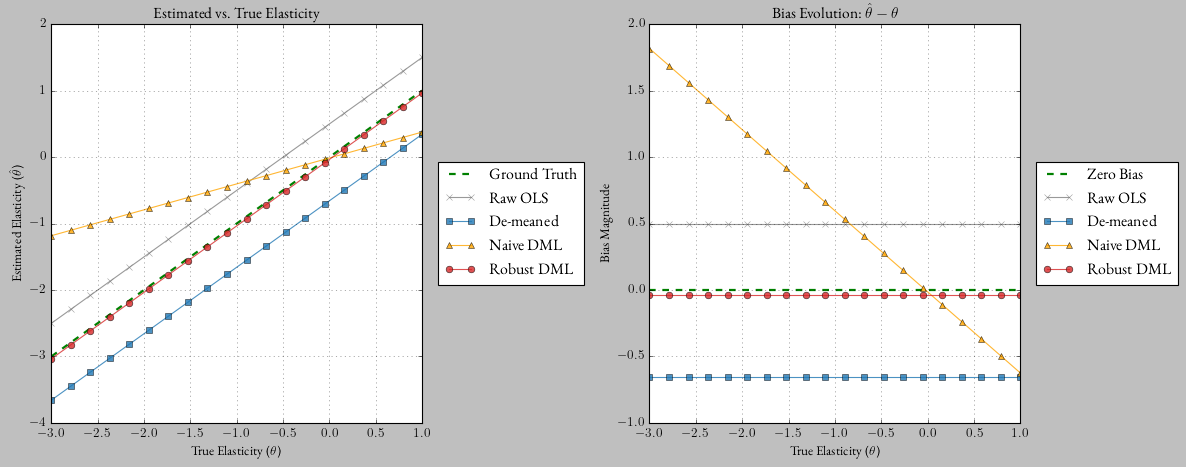

In [6]:

# ===== 敏感性分析: Results and Diagnostics =====

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- 图 1: 估计值 vs 真实值 (Estimated vs True) ---
# 理想情况是落在对角线 y=x 上
ax1 = axes[0]
colors = {
    "Raw OLS": "gray",
    "De-meaned": "tab:blue",
    "Naive DML": "orange",
    "Robust DML": "tab:red",
}
markers = {"Raw OLS": "x", "De-meaned": "s", "Naive DML": "^", "Robust DML": "o"}

# 绘制参考线 (Truth)
ax1.plot(
    df_res["True Theta"],
    df_res["True Theta"],
    color="green",
    linestyle="--",
    linewidth=2,
    label="Ground Truth",
)

for method in colors.keys():
    ax1.plot(
        df_res["True Theta"],
        df_res[method],
        marker=markers[method],
        color=colors[method],
        label=method,
        alpha=0.8,
    )

ax1.set_title("Estimated vs. True Elasticity", fontsize=14, fontweight="bold")
ax1.set_xlabel("True Elasticity ($\\theta$)")
ax1.set_ylabel("Estimated Elasticity ($\\hat{\\theta}$)")
ax1.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax1.grid(True, linestyle=":", alpha=0.6)


# --- 图 2: 偏差趋势 (Bias vs True) ---
# 理想情况是落在 y=0 上
ax2 = axes[1]

# 绘制参考线 (Zero Bias)
ax2.axhline(0, color="green", linestyle="--", linewidth=2, label="Zero Bias")

for method in colors.keys():
    ax2.plot(
        df_res["True Theta"],
        df_res[f"{method} Bias"],
        marker=markers[method],
        color=colors[method],
        label=method,
        alpha=0.8,
    )

ax2.set_title(
    "Bias Evolution: $\\hat{\\theta} - \\theta$", fontsize=14, fontweight="bold"
)
ax2.set_xlabel("True Elasticity ($\\theta$)")
ax2.set_ylabel("Bias Magnitude")
ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax2.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig("elasticity_sensitivity_analysis.pdf")
plt.show()
